# Automatic Number Plate Recognition System

# 1. Dependencies

**Note**: Newer Python versions require users to install dependencies in a virtual environment. Learn how to create a virtual environment [here](https://docs.python.org/3/library/venv.html), or if using Visual Studio Code, [here](https://code.visualstudio.com/docs/python/environments).

In [22]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [23]:
!pip install ultralytics scikit-learn tqdm

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as xet
import cv2
import re
import os
from glob import glob

from sklearn.model_selection import train_test_split
import shutil

from tqdm import tqdm

Make sure CUDA is available. CUDA is a program created by Nvidia that gives PyTorch direct access to the GPU, making processing way more efficient. CUDA cores (or devices) are computer cores that are specialised for parallel computing. If there aren't any CUDA cores available, it's probably because you're running the notebook on a CPU, not a GPU. Google Colab offers


In [25]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# 2. Preprocessing

## 2.1 Define preprocessing

In [43]:
def preprocess_image(image):
 
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return image_gray

In [44]:
def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png'))]

    # Process each image
    for filename in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error reading image: {filename}")
            continue

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Save the processed image
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, processed_image)

## 2.2 Preprocess images in dataset

In [45]:
input_directory = "dataset/images"
output_directory = "dataset/preprocessed_images"

process_dataset(input_directory, output_directory)

Processing images: 100%|████████████████████████████████████████████████████████████| 433/433 [00:03<00:00, 142.36it/s]


# 3. Data

## 3.1 Find data

In [46]:
dataset_path = "dataset"

In [47]:
def extract_number_from_str(filename):
    """Function to find a given image or label number to adjoin images and labels together."""
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [48]:
# Store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [49]:
# get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
assert xml_files, "Couldn't find dataset. Make sure to upload the dataset to Colab."

In [50]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=extract_number_from_str):

    info = xet.parse(filename)
    root = info.getroot()

    # Extract bounding box coordinates
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,dataset\preprocessed_images\Cars0.png,226,419,125,173,500,268
1,dataset\preprocessed_images\Cars1.png,134,262,128,160,400,248
2,dataset\preprocessed_images\Cars2.png,229,270,176,193,400,400
3,dataset\preprocessed_images\Cars3.png,142,261,128,157,400,225
4,dataset\preprocessed_images\Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,dataset\preprocessed_images\Cars428.png,142,258,128,157,400,225
429,dataset\preprocessed_images\Cars429.png,86,208,166,195,301,400
430,dataset\preprocessed_images\Cars430.png,38,116,159,197,400,225
431,dataset\preprocessed_images\Cars431.png,55,343,82,147,400,192


## 3.2 Split data

In [51]:
# Split dataset for training, testing and validation
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
Number of images in each set
Training:   {len(train)} images
Validation:  {len(val)} images
Testing:     {len(test)} images
''')


Number of images in each set
Training:   345 images
Validation:  44 images
Testing:     44 images



## 3.3 Convert data to YOLO format

In [52]:
def make_split_folder_in_yolo_format(split_name, split_df):
    # folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plates', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plates', split_name, 'images')

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
        os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [53]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets\cars_license_plates\train\images' and 'datasets\cars_license_plates\train\labels'
Created 'datasets\cars_license_plates\val\images' and 'datasets\cars_license_plates\val\labels'
Created 'datasets\cars_license_plates\test\images' and 'datasets\cars_license_plates\test\labels'


# Object detection and bounding box

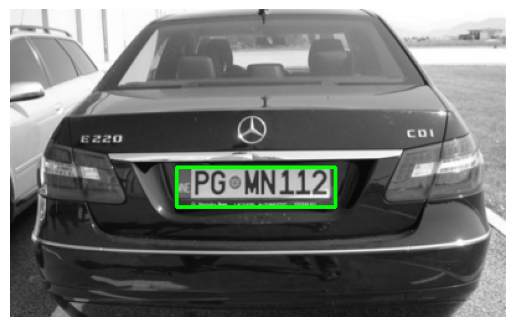

In [54]:
image_dir = 'datasets/cars_license_plates/train/images'
label_dir = 'datasets/cars_license_plates/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [55]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [56]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [57]:
os.environ['WANDB_MODE'] = 'offline'

In [58]:
def train_with_preprocessing(model, train_data):
    def preprocessed_dataset(data):
        for batch in data:
            yield [preprocess_image(img) for img in batch]

    results = model.train(data=preprocessed_dataset(train_data), epochs=100, imgsz=640)

In [60]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

New https://pypi.org/project/ultralytics/8.3.18 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.9  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 12.5MB/s]


AMP: checks passed 


train: Scanning E:\Documents\Desktop\project\2.gray_convert\datasets\cars_license_plates\train\labels... 345 images, 0 

train: New cache created: E:\Documents\Desktop\project\2.gray_convert\datasets\cars_license_plates\train\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 5109.66it/s]
val: Scanning E:\Documents\Desktop\project\2.gray_convert\datasets\cars_license_plates\val\labels... 44 images, 0 backg

val: New cache created: E:\Documents\Desktop\project\2.gray_convert\datasets\cars_license_plates\val\labels.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 5352.67it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.671G       1.86      3.612      1.391         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44    0.00365      0.841      0.108     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.642G      1.618      2.387      1.102         17        320: 100%|██████████| 22/22 [00:01<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44     0.0042      0.909      0.179     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.644G      1.591      1.558       1.18         16        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44    0.00386      0.841     0.0344     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.642G      1.568      1.487      1.187         18        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44          1      0.115      0.329      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.642G       1.54       1.36      1.171         13        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.792       0.25      0.366      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.642G      1.546      1.363      1.185         12        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44          1      0.245      0.517        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.642G      1.536      1.224      1.167         19        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.68      0.568      0.693      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.644G      1.481      1.163      1.144         17        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.746      0.736      0.735      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.642G       1.45      1.164      1.129         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.782      0.773      0.769      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.642G      1.507      1.147      1.184         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.75      0.841      0.833      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.642G      1.404      1.061      1.089         16        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.781      0.864       0.81      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.642G      1.435      1.014      1.137         14        320: 100%|██████████| 22/22 [00:01<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.948      0.826      0.883       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.642G      1.492      1.078      1.146         14        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.857      0.815      0.878      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.644G      1.464      1.037      1.127         19        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.737      0.864      0.848       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.642G      1.365      1.009      1.096         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.888      0.899      0.902      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.642G      1.347     0.9787      1.074         16        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.696      0.818      0.819      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.642G      1.342     0.9334      1.105         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.84      0.818      0.855      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.642G      1.358     0.8972      1.085         13        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.822      0.841      0.828      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.642G      1.361     0.8897       1.06         20        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.901      0.841      0.887      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.642G      1.335     0.8812      1.078         21        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.811      0.779      0.802      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.642G      1.253     0.8263      1.037         21        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.922      0.795      0.891      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.642G      1.265     0.8393      1.048         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.882      0.818      0.877      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.642G      1.236     0.8248      1.036         23        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.811      0.864      0.876      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.642G      1.257     0.8285       1.05         20        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.903      0.843      0.901      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.642G      1.284     0.8278       1.02         19        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.839      0.827      0.882      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.642G      1.287     0.8084      1.061         21        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.858      0.841      0.871      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.642G      1.208     0.7611      1.037         18        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.812      0.884      0.887      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.642G      1.167     0.7723      1.005         17        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.845      0.886      0.893      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.642G      1.212     0.7558      1.043         17        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.842      0.864      0.881        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.642G      1.153     0.7617      1.019         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.854      0.886      0.887      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.642G      1.173     0.7642     0.9968         14        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.855      0.864      0.874      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.642G      1.174     0.7425       1.01         20        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.922      0.807      0.882      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.642G      1.198     0.7126      1.012         19        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.877      0.809      0.899      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.642G      1.176     0.7364      1.017         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.89      0.841      0.905      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.642G      1.173     0.7172      1.018         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.902      0.886      0.895        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.642G      1.126     0.6886      1.001         18        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.928      0.881      0.914      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.642G      1.144     0.6971      1.001         20        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.975       0.88      0.922       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.642G      1.143     0.6966      1.003         16        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44          1      0.859      0.923      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.642G      1.082     0.6571     0.9802         19        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.911      0.886      0.907      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.642G      1.102     0.6777     0.9913         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.974       0.84      0.905      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.642G      1.092     0.6848     0.9849         24        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.842      0.864      0.849      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.642G      1.079     0.6428     0.9895         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.903      0.847      0.869       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.642G      1.029     0.6399     0.9611         12        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.904      0.858      0.858      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.642G      1.129     0.6967      1.008         12        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.826      0.862      0.844      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.642G      1.048     0.6643     0.9729         12        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.858      0.841      0.864      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.642G      1.061     0.6469      0.984         19        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.885      0.886      0.891      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.642G      1.048     0.6378      0.972         18        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.93      0.907      0.938      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.642G      1.047     0.6347      0.975         17        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.856      0.955      0.943      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.642G      1.012     0.6356     0.9544         20        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44       0.89      0.909       0.92      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.642G      1.006     0.6259     0.9607         20        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.884      0.867      0.895      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.642G      1.013     0.6355     0.9751         21        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.917      0.841      0.907      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.644G      1.004     0.6192     0.9617         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.878      0.886      0.893      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.642G     0.9926     0.6152     0.9565         19        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.907      0.886      0.898      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.642G      1.032     0.6137     0.9565         20        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.807      0.886      0.896       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.642G     0.9935      0.613     0.9528         20        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.899      0.864      0.881       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.642G     0.9795      0.619     0.9511         14        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.891      0.841       0.89      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.642G     0.9862     0.5896     0.9512         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.942      0.864      0.915      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.642G     0.9791     0.6056     0.9505         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.885      0.886      0.897      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.642G     0.9883     0.5891     0.9593         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.88      0.886      0.916      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.642G     0.9023     0.5649     0.9225         20        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.95      0.857      0.917      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.642G       0.95      0.567     0.9434         20        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.906      0.881      0.899      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.642G     0.9378      0.577     0.9311         18        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.936      0.909       0.94      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.642G     0.9045     0.5571       0.93         18        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.888      0.904      0.919      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.642G     0.9283     0.5518     0.9347         12        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.889      0.908      0.919      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.642G     0.8992     0.5506     0.9314         17        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.905      0.869      0.921      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.642G     0.9064     0.5567     0.9463         17        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.886      0.885      0.869      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.642G     0.8932     0.5464     0.9371         18        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.908      0.897      0.922      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.642G     0.8676     0.5148     0.9182         22        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.938      0.818      0.888      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.642G     0.8648     0.5357      0.925         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.958      0.841      0.888      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.642G     0.8922     0.5418     0.9326         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.926      0.841      0.909      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.642G     0.9126     0.5444     0.9369         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.93      0.841      0.885      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.642G      0.864      0.509     0.9191         14        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.927      0.861      0.899      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.642G      0.907     0.5322     0.9493         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.861      0.886      0.919      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.642G     0.8545     0.5181     0.9099         12        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.903      0.846      0.914      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.642G     0.8985     0.5392     0.9371         10        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.926      0.818      0.897      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.642G     0.8385     0.4999       0.92         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.863       0.86      0.916      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.642G     0.8534     0.5076     0.9054         24        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44        0.9      0.818      0.884      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.642G      0.872     0.5176     0.9259         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.926      0.864        0.9      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.642G     0.8593     0.5127     0.9173         14        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.931      0.864      0.918      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.642G     0.8247     0.5132     0.9224         12        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.903      0.864      0.893      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.642G     0.8127     0.4967     0.9185         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.868      0.909       0.92      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.642G     0.8428     0.5062     0.9172         23        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.874      0.886      0.897      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.642G     0.8272     0.4869     0.9167         11        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.883      0.909      0.933      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.642G     0.8405     0.5041     0.9232         18        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.864      0.886      0.899      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.642G     0.8012      0.493     0.9021         19        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.867      0.885      0.902      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.642G     0.7997     0.4928     0.9059         10        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.921      0.886      0.921      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.642G     0.7915     0.4932     0.9067         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.928      0.885      0.923      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.642G     0.8233     0.4883     0.9256         18        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.953      0.841      0.922      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.642G     0.7821     0.4682     0.9056         20        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.959      0.841      0.919      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.642G     0.7794     0.4764     0.8958         21        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.868      0.909      0.924      0.521


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.642G      1.018     0.5845     0.9597          9        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.922      0.841      0.884      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.642G      1.026     0.5385     0.9805          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.939      0.841      0.897      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.642G      1.024     0.5382     0.9986          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.95      0.856      0.913      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.642G     0.9967     0.5236     0.9638          9        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.888      0.901      0.915      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      0.64G     0.9643     0.5243     0.9734          9        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.866      0.909      0.918      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.642G     0.9505     0.5121     0.9447          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.889      0.932      0.936      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.642G     0.9712     0.5055     0.9607          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.886      0.932      0.936      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.642G      0.952     0.5002     0.9491          9        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.864      0.909      0.919      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.64G     0.9222     0.4894     0.9648          9        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.864      0.909      0.918      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.642G     0.9181     0.4908     0.9486          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.864      0.909      0.918      0.542



100 epochs completed in 0.043 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 5.6MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 5.6MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.9  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.864      0.909      0.918      0.548
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000015F599054E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

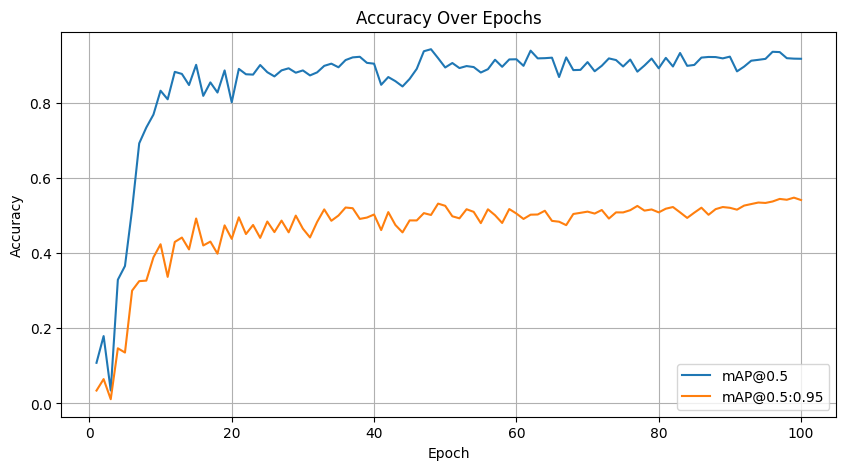

In [61]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=extract_number_from_str)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# save model
model.save('anpr-v1.pt')

# Test and predictions

In [63]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 E:\Documents\Desktop\project\2.gray_convert\dataset\preprocessed_images\Cars425.png: 160x320 1 license_plate, 25.3ms
Speed: 0.0ms preprocess, 25.3ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)


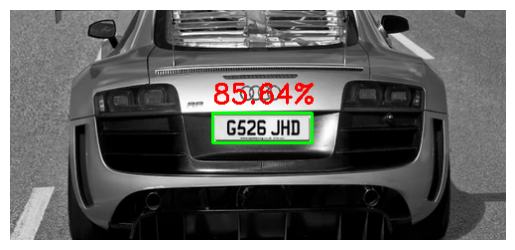

In [64]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 E:\Documents\Desktop\project\2.gray_convert\dataset\preprocessed_images\Cars181.png: 320x192 1 license_plate, 29.5ms
Speed: 1.0ms preprocess, 29.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 192)


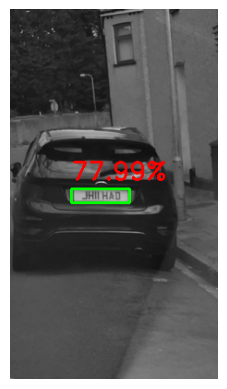

In [65]:
predict_and_plot(test.iloc[2].img_path)